In [44]:
import spacy
import pandas as pd
import numpy as np
from nlpia2.constants import  SRC_DATA_DIR as DATA_DIR
pd.options.display.max_columns = 2000
pd.options.display.max_colwidth = 120

In [8]:
# spacy.cli.download('en_core_web_md')
df = pd.read_csv(DATA_DIR / "nlpia_lines.csv.gz")
df3 = df[df["filename"] == "Chapter-03_Math-with-Words-TF-IDF-Vectors.adoc"]
texts = df3['text'][df3['is_text']]
len(texts)

528

In [10]:
nlp = spacy.load("en_core_web_md")
embeddings = np.array(list(texts.apply(lambda s: list(nlp(s).vector)).values))
embeddings.shape

(528, 300)

In [11]:
dfe = pd.DataFrame([list(x / np.linalg.norm(x)) for x in embeddings])
heatmap = dfe.values.dot(dfe.values.T)
heatmap.shape

(528, 528)

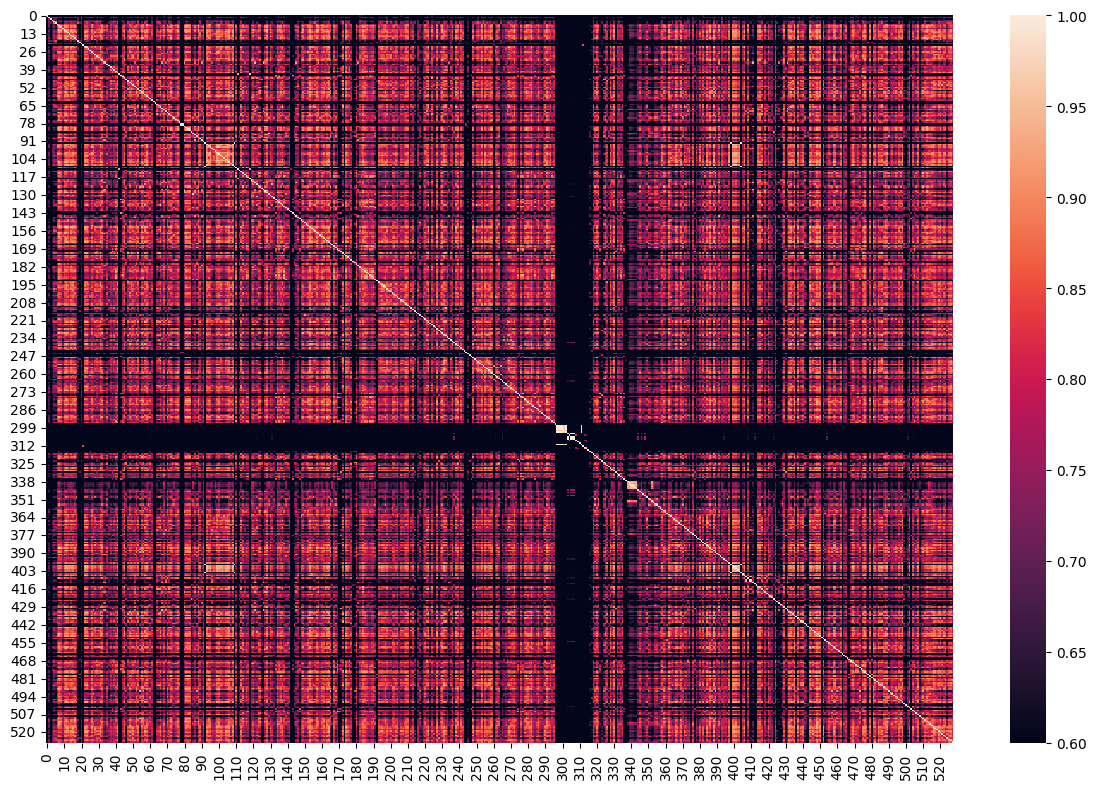

In [15]:
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]  # inches


hm = sn.heatmap(data=heatmap, vmin=0.6, vmax=1)
plt.tight_layout()
plt.show()

There is a white square of identical sentences in the middle of some very unique sentences.
Notice the white box at around row 300 and column 300?
The black stripes around it extend from about row 295 to 320, so you probably are curious about what these sentences are saying that's so strange.

In [43]:
texts[295:320]

4383        We'll start by importing a small and interesting python package called `this`, and examining some of its constants:
4389                                                                                           Gur Mra bs Clguba, ol Gvz Crgref
4390                                                                                             Ornhgvshy vf orggre guna htyl.
4391                                                                                          Rkcyvpvg vf orggre guna vzcyvpvg.
4392                                                                                             Fvzcyr vf orggre guna pbzcyrk.
4393                                                                                        Pbzcyrk vf orggre guna pbzcyvpngrq.
4394                                                                                                Syng vf orggre guna arfgrq.
4395                                                                                               Fcnef

In [28]:
closeones = []
for i1, text1 in enumerate(texts):
    for i2, text2 in enumerate(texts[i1 + 1:]):
        i3 = i2 + i1 + 1
        if 1.0 > heatmap[i1][i3] > 0.95:
            closeones.append(
                dict(
                    row=i1,
                    col=i3,
                    value=heatmap[i1][i3],
                    text1=text1,
                    text1b=df.text.iloc[i1],
                    text2=text2,
                    text2b=df.text.iloc[i3],
                )
            )
dfclose = pd.DataFrame(closeones).sort_values('value')
dfclose
dfclose[["row", "col", "value", "text1", "text2"]].tail()


,row,col,value,text1,text2
40,297,300,1.0,Ornhgvshy vf orggre guna htyl.,Pbzcyrk vf orggre guna pbzcyvpngrq.
39,297,299,1.0,Ornhgvshy vf orggre guna htyl.,Fvzcyr vf orggre guna pbzcyrk.
38,297,298,1.0,Ornhgvshy vf orggre guna htyl.,Rkcyvpvg vf orggre guna vzcyvpvg.
55,300,311,1.0,Pbzcyrk vf orggre guna pbzcyvpngrq.,Abj vf orggre guna arire.
42,297,302,1.0,Ornhgvshy vf orggre guna htyl.,Fcnefr vf orggre guna qrafr.


The top 5 most similar sentences are lines from the encrypted Zen of Python poem.

In [31]:
doc1 = nlp(dfclose['text1'].tail().iloc[0])
doc2 = nlp(dfclose['text2'].tail().iloc[0])
doc1, doc2

(Ornhgvshy vf orggre guna htyl., Pbzcyrk vf orggre guna pbzcyvpngrq.)

In [34]:
doc1.vector.dot(nlp('.').vector) / np.linalg.norm(nlp('.').vector) ** 2

0.1581501090646956

In [42]:
pd.DataFrame([
    [tok.text for tok in doc1],
    [tok.has_vector for tok in doc1],
    [tok.text for tok in doc2],
    [tok.has_vector for tok in doc2]
])

,0,1,2,3,4,5
0,Ornhgvshy,vf,orggre,guna,htyl,.
1,False,True,False,True,False,True
2,Pbzcyrk,vf,orggre,guna,pbzcyvpngrq,.
3,False,True,False,True,False,True


Only a few of these encrypted tokens have any semantic vector in Spacy's vocabulary. And it's the same 2 or 3 ROT-13 encoded words that are duplicated in the other lines of the poem. So this means that these lines will have the exact same embedding vectors, because the SpaCy vector is just the average or mean of all the vectors for the words that are in its vocabulary.

What about the slightly less similar sentences in Chapter 3?

In [49]:
dfclose[["row", "col", "value", "text1", "text2"]][dfclose['value'] < .999].tail(10)

,row,col,value,text1,text2
8,23,388,0.964515,Inverse document frequency means that you'll divide each of those word counts by the number of documents in which th...,"Word counts and _n_-gram counts are useful, but pure word count, even when normalized by the length of the document,..."
67,400,401,0.964844,"In 2015, Google apologized when black users complained that an image-identification algorithm in its Photos applicat...","Biometric data about race may also be inferred, rather than observed. For example, a 2012 study showed that names co..."
31,153,444,0.965488,"For now just know that each element of a vector is used to represent the count, weight or importance of a word in th...","It relates a specific word or token to a specific document in a specific corpus, and then it assigns a numeric value..."
26,99,105,0.966342,"As algorithms expand their ability to organize society, politics, institutions, and behavior, sociologists have beco...","Problems in understanding, researching, and discovering algorithmic bias persist due to the proprietary nature of al..."
66,399,401,0.969218,Algorithms have been criticized as a method for obscuring racial prejudices in decision-making. Because of how certa...,"Biometric data about race may also be inferred, rather than observed. For example, a 2012 study showed that names co..."
12,42,118,0.976848,"Counter({',': 5, 'and': 2, 'It': 1, 'has': 1, 'also': 1, 'arisen': 1, ...})","Counter({'Algorithmic': 3, 'bias': 6, 'describes': 1, 'systematic': 2, ..."
20,85,129,0.984580,This is where things get really meaningful.,This is when things get really interesting.
60,340,341,0.985095,Simple is better than complex.,Complex is better than complicated.
17,78,79,0.988527,"TF(\text{""dog""}, document_A) = 3/30 = .1","TF(\text{""dog""}, document_B) = 100/580000 = .00017"
68,409,410,0.992805,"Term Frequency of ""and"" in intro is: 0.0292","Term Frequency of ""and"" in discrimination chapter is: 0.0303"


It looks like our natural language line filter accidentally included some machine language text from the code blocks and formulas. And the Zen of Python is a little repetitive as well.

But there are also some longer passages that seem similar to each other. So these might be a good place to start if your editor was asking you to try to shorten this chapter a bit. 